# `clisops` regridding functionalities - powered by `xesmf`

##### Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cf_xarray as cfxr
import xesmf as xe
import cartopy.crs as ccrs

from pathlib import Path
from git import Repo
import os

import clisops as cl # atm. the regrid-main-martin branch of clisops
import clisops.ops as clops
import clisops.core as clore
from clisops.utils import dataset_utils
from roocs_grids import get_grid_file, grid_dict, grid_annotations

print(f"Using cf_xarray in version {cfxr.__version__}")
print(f"Using xESMF in version {xe.__version__}")
print(f"Using clisops in version {cl.__version__}")

xr.set_options(display_style='html');

## Turn off warnings?
import warnings
warnings.simplefilter("ignore")

Using cf_xarray in version 0.6.2.dev2+g1fde526
Using xESMF in version 0.6.1
Using clisops in version 0.6.5


#### Initialize test data

In [2]:
# Initialize mini-esgf-data
MINIESGF_URL="https://github.com/roocs/mini-esgf-data"
branch = "master"
MINIESGF = Path(Path.home(),".mini-esgf-data", branch)

# Retrieve mini-esgf test data
if not os.path.isdir(MINIESGF):
    repo = Repo.clone_from(MINIESGF_URL, MINIESGF)
    repo.git.checkout(branch)
else:
    repo = Repo(MINIESGF)
    repo.git.checkout(branch)
    repo.remotes[0].pull()
    
MINIESGF=Path(MINIESGF,"test_data")

<a id='top'></a>
## `clisops.ops.regrid`

One-line remapping with `clisops.ops.regrid`
```python
def regrid(
    ds: Union[xarray.Dataset, xarray.DataArray, str, Path],
    *,
    method="nearest_s2d",
    adaptive_masking_threshold=0.5,
    grid: Union[xarray.Dataset, int, float, tuple, str] = "adaptive",
    output_dir: Optional[Union[str, Path]] = None,
    output_type="netcdf",
    split_method="time:auto",
    file_namer="standard",
)    
```
The different options for the `method`, `grid` and `adaptive_masking_threshold` parameters are described in below sections:
* [clisops.core.Grid](#clisops.core.Grid)
* [clisops.core.Weights](#clisops.core.Weights)
* [clisops.core.regrid](#clisops.core.regrid)

### Remap global `xarray.Dataset` to a global one degree grid

##### Load the dataset

In [3]:
ds_vert_path = Path(MINIESGF, "badc/cmip6/data/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/historical/r1i1p1f1/AERmon/"
                              "o3/gn/v20190710/o3_AERmon_MPI-ESM1-2-LR_historical_r1i1p1f1_gn_185001.nc")
ds_vert = xr.open_dataset(ds_vert_path)
ds_vert

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 96, lev: 3, lon: 192, time: 1)
Coordinates:
  * time       (time) datetime64[ns] 1850-01-16T12:00:00
  * lon        (lon) float64 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
  * lat        (lat) float64 -88.57 -86.72 -84.86 -83.0 ... 84.86 86.72 88.57
  * lev        (lev) float64 0.9961 0.9826 0.959
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] ...
    lon_bnds   (lon, bnds) float64 ...
    lat_bnds   (lat, bnds) float64 ...
    lev_bnds   (lev, bnds) float64 ...
    ap         (lev) float64 ...
    b          (lev) float64 ...
    ap_bnds    (lev, bnds) float64 ...
    b_bnds     (lev, bnds) float64 ...
    ps         (time, lat, lon) float32 ...
    o3         (time, lev, lat, lon) float32 ...
Attributes: (12/49)
    CDI:                    Climate Data Interface version 1.9.8 (https://mpi...
    history:                Tue Oct 26 11:48:46 2021: cdo sellevidx,1/3 -selt...
    source:                 MPI-ESM1.2-LR (2017): \naerosol: none, prescribed...
    institution:            Max Planck Institute for Meteorology
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    ...                     ...
    variable_id:            o3
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by MPI-M is licensed un...
    cmor_version:           3.5.0
    tracking_id:            hdl:21.14100/52bee89e-e989-4005-8663-e60210d421d5
    CDO:                    Climate Data Operators version 1.9.8 (https://mpi...

##### Remap to global 1 degree grid with the bilinear method

In [4]:
ds_remap = clops.regrid(ds_vert, method="bilinear", grid="1deg", output_type="xarray")[0]
ds_remap

2021-11-08 20:06:05,155 - /home/maurti/git/clisopsdev/clisops/clisops/ops/base_operation.py - INFO - Processing Regrid for times: ('1850-01-16', '1850-01-16')
2021-11-08 20:06:05,156 - /home/maurti/git/clisopsdev/clisops/clisops/utils/output_utils.py - INFO - format_writer=None, output_type=xarray
2021-11-08 20:06:05,156 - /home/maurti/git/clisopsdev/clisops/clisops/utils/output_utils.py - INFO - Returning output as <class 'xarray.core.dataset.Dataset'>


<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 180, lev: 3, lon: 360, time: 1)
Coordinates:
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon        (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
    lat_bnds   (lat, bnds) float64 -90.0 -89.0 -89.0 -88.0 ... 89.0 89.0 90.0
    lon_bnds   (lon, bnds) float64 0.0 1.0 1.0 2.0 ... 358.0 359.0 359.0 360.0
  * time       (time) datetime64[ns] 1850-01-16T12:00:00
    time_bnds  (time, bnds) datetime64[ns] 1850-01-01 1850-02-01
    ap         (lev) float64 0.0 0.0 36.03
    b          (lev) float64 0.9961 0.9826 0.9586
  * lev        (lev) float64 0.9961 0.9826 0.959
    ap_bnds    (lev, bnds) float64 0.0 0.0 0.0 0.0 0.0 72.06
    b_bnds     (lev, bnds) float64 1.0 0.9923 0.9923 0.973 0.973 0.9442
    lev_bnds   (lev, bnds) float64 1.0 0.9923 0.9923 0.973 0.973 0.9449
Dimensions without coordinates: bnds
Data variables:
    ps         (time, lat, lon) float32 6.937e+04 6.936e+04 ... 1.012e+05
    o3         (time, lev, lat, lon) float32 1.636e-08 1.636e-08 ... 2.324e-08
Attributes: (12/54)
    CDI:                          Climate Data Interface version 1.9.8 (https...
    history:                      Tue Oct 26 11:48:46 2021: cdo sellevidx,1/3...
    source:                       MPI-ESM1.2-LR (2017): \naerosol: none, pres...
    institution:                  Max Planck Institute for Meteorology
    Conventions:                  CF-1.7 CMIP-6.2
    activity_id:                  CMIP
    ...                           ...
    grid_original:                gn
    grid_label_original:          gn
    nominal_resolution_original:  250 km
    regrid_operation:             bilinear_96x192_180x360_peri
    regrid_tool:                  xESMF_v0.6.1
    regrid_weights_uid:           20d38455170b1db562edb4f5e06d3cc6_d24f4f689f...

##### Plot the remapped data

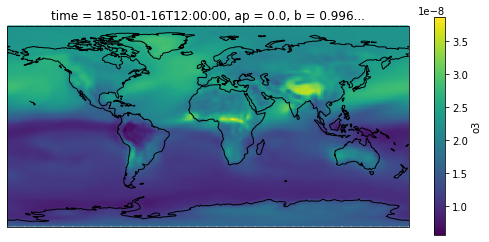

In [5]:
plt.figure(figsize=(9,4));
ax = plt.axes(projection=ccrs.PlateCarree());
ds_remap.o3.isel(time=0, lev=0).plot.pcolormesh(ax=ax, x="lon", y="lat", shading="flat");
ax.coastlines();

### Remap regional `xarray.Dataset` to a regional grid of adaptive resolution
Adaptive resolution means, that the regular lat-lon target grid will have approximately same resolution than the source grid.

##### Load the dataset

In [6]:
ds_cordex_path = Path(MINIESGF, "pool/data/CORDEX/data/cordex/output/EUR-22/GERICS/MPI-M-MPI-ESM-LR/"
                                "rcp85/r1i1p1/GERICS-REMO2015/v1/mon/tas/v20191029/"
                                "tas_EUR-22_MPI-M-MPI-ESM-LR_rcp85_r1i1p1_GERICS-REMO2015_v1_mon_202101.nc")
ds_cordex = xr.open_dataset(ds_cordex_path)
ds_cordex

<xarray.Dataset>
Dimensions:                     (bnds: 2, rlat: 201, rlon: 225, time: 1, vertices: 4)
Coordinates:
    height                      float64 ...
    lat                         (rlat, rlon) float32 ...
    lon                         (rlat, rlon) float32 ...
  * rlat                        (rlat) float64 -22.88 -22.66 ... 20.9 21.12
  * rlon                        (rlon) float64 -29.86 -29.64 ... 19.2 19.42
  * time                        (time) datetime64[ns] 2021-01-16T12:00:00
Dimensions without coordinates: bnds, vertices
Data variables:
    lat_vertices                (rlat, rlon, vertices) float32 ...
    lon_vertices                (rlat, rlon, vertices) float32 ...
    rotated_latitude_longitude  int32 ...
    tas                         (time, rlat, rlon) float32 ...
    time_bnds                   (time, bnds) datetime64[ns] ...
Attributes: (12/35)
    institution:                    Helmholtz-Zentrum Geesthacht, Climate Ser...
    institute_id:                   GERICS
    experiment_id:                  rcp85
    source:                         GERICS-REMO2015
    model_id:                       GERICS-REMO2015
    forcing:                        N/A
    ...                             ...
    parent_experiment:              N/A
    modeling_realm:                 atmos
    realization:                    1
    cmor_version:                   2.9.1
    tracking_id:                    hdl:21.14103/77bb3489-7951-4f31-bf63-3022...
    NCO:                            netCDF Operators version 4.7.5 (Homepage ...

##### Take a look at the grid

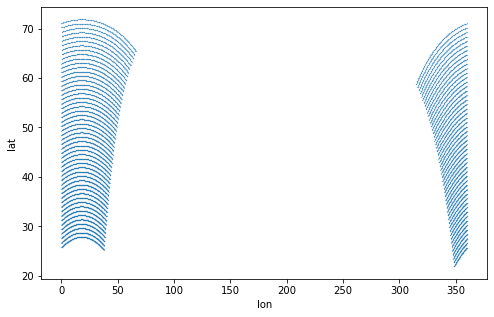

In [7]:
plt.figure(figsize=(8,5))
plt.scatter(ds_cordex['lon'][::4], ds_cordex['lat'][::4], s=0.05)  
plt.xlabel('lon');
plt.ylabel('lat');

##### Remap to global 1 degree grid with the bilinear method

In [8]:
ds_remap = clops.regrid(ds_cordex, method="bilinear", grid="adaptive", output_type="xarray")[0]
ds_remap

2021-11-08 20:06:06,735 - /home/maurti/git/clisopsdev/clisops/clisops/ops/base_operation.py - INFO - Processing Regrid for times: ('2021-01-16', '2021-01-16')
2021-11-08 20:06:06,736 - /home/maurti/git/clisopsdev/clisops/clisops/utils/output_utils.py - INFO - format_writer=None, output_type=xarray
2021-11-08 20:06:06,736 - /home/maurti/git/clisopsdev/clisops/clisops/utils/output_utils.py - INFO - Returning output as <class 'xarray.core.dataset.Dataset'>


<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 201, lon: 225, time: 1)
Coordinates:
  * lat        (lat) float64 21.89 22.14 22.39 22.64 ... 71.12 71.37 71.62 71.87
  * lon        (lon) float64 -45.38 -44.88 -44.38 -43.88 ... 65.18 65.67 66.17
    lat_bnds   (lat, bnds) float64 21.76 22.01 22.01 22.26 ... 71.75 71.75 72.0
    lon_bnds   (lon, bnds) float64 -45.62 -45.13 -45.13 ... 65.92 65.92 66.42
    height     float64 2.0
  * time       (time) datetime64[ns] 2021-01-16T12:00:00
    time_bnds  (time, bnds) datetime64[ns] 2021-01-01 2021-02-01
Dimensions without coordinates: bnds
Data variables:
    tas        (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
Attributes: (12/40)
    institution:                    Helmholtz-Zentrum Geesthacht, Climate Ser...
    institute_id:                   GERICS
    experiment_id:                  rcp85
    source:                         GERICS-REMO2015
    model_id:                       GERICS-REMO2015
    forcing:                        N/A
    ...                             ...
    NCO:                            netCDF Operators version 4.7.5 (Homepage ...
    grid:                           regional regular_lat_lon 201x225 (45225 c...
    grid_label:                     gr
    regrid_operation:               bilinear_201x225_201x225
    regrid_tool:                    xESMF_v0.6.1
    regrid_weights_uid:             05603f6f046b266ba6bc164c5b3209bf_cbfbd94f...

##### Plot the remapped data

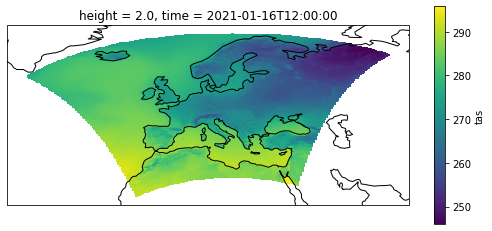

In [9]:
plt.figure(figsize=(9,4));
ax = plt.axes(projection=ccrs.PlateCarree());
ds_remap.tas.isel(time=0).plot.pcolormesh(ax=ax, x="lon", y="lat", shading="flat");
ax.coastlines();

### Remap irregular `xarray.Dataset` to a global grid of adaptive resolution

For irregular grids, at least for the moment, only the nearest neighbour remapping method is supported.

##### Load the dataset

In [10]:
ds_icono_path = Path(MINIESGF, "badc/cmip6/data/CMIP6/CMIP/MPI-M/ICON-ESM-LR/historical/"
                               "r1i1p1f1/Omon/thetao/gn/v20210215/"
                               "thetao_Omon_ICON-ESM-LR_historical_r1i1p1f1_gn_185001.nc")
ds_icono = xr.open_dataset(ds_icono_path)
ds_icono

<xarray.Dataset>
Dimensions:         (bnds: 2, i: 235403, lev: 2, time: 1, vertices: 3)
Coordinates:
  * time            (time) datetime64[ns] 1850-01-16T12:00:00
    longitude       (i) float64 ...
    latitude        (i) float64 ...
  * lev             (lev) float64 6.0 17.0
Dimensions without coordinates: bnds, i, vertices
Data variables:
    time_bnds       (time, bnds) datetime64[ns] ...
    longitude_bnds  (i, vertices) float64 ...
    latitude_bnds   (i, vertices) float64 ...
    lev_bnds        (lev, bnds) float64 ...
    thetao          (time, lev, i) float32 ...
Attributes: (12/51)
    CDI:                    Climate Data Interface version 1.9.8 (https://mpi...
    history:                Tue Oct 26 11:15:49 2021: cdo sellevidx,1/2 -selt...
    source:                 ICON-ESM-LR (2017): \naerosol: none, prescribed M...
    institution:            Max Planck Institute for Meteorology
    Conventions:            CF-1.7 CMIP-6.2
    CDI_grid_type:          unstructured
    ...                     ...
    variable_id:            thetao
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by MPI-M is licensed un...
    cmor_version:           3.6.0
    tracking_id:            hdl:21.14100/5e828f18-2231-443c-b560-b1e4ff2a8ef9
    CDO:                    Climate Data Operators version 1.9.8 (https://mpi...

##### Take a look at the grid

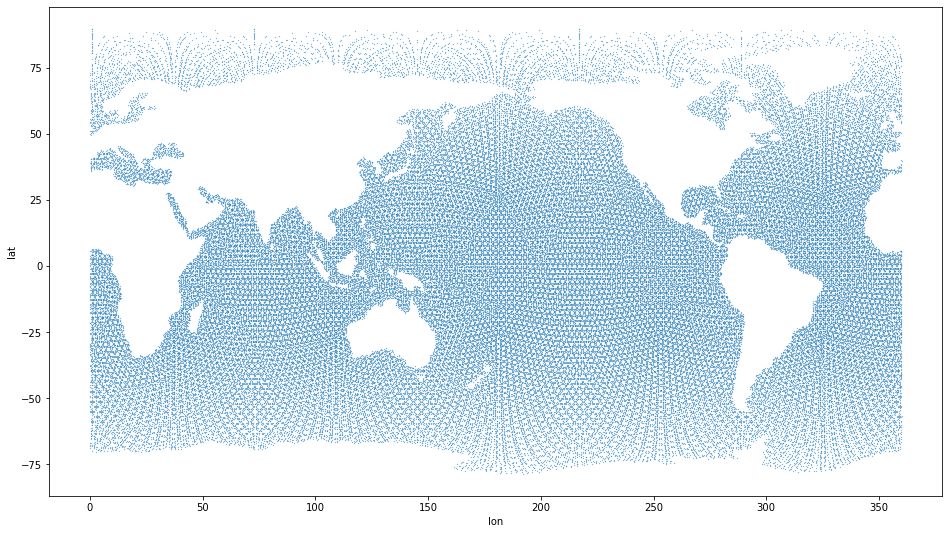

In [11]:
plt.figure(figsize=(16,9))
plt.scatter(ds_icono['longitude'][::2], ds_icono['latitude'][::2], s=0.05)  
plt.xlabel('lon');
plt.ylabel('lat');

##### Remap to global grid of adaptive resolution with the nearest neighbour method

In [12]:
ds_remap = clops.regrid(ds_icono, method="nearest_s2d", grid="adaptive", output_type="xarray")[0]
ds_remap

2021-11-08 20:06:11,485 - /home/maurti/git/clisopsdev/clisops/clisops/ops/base_operation.py - INFO - Processing Regrid for times: ('1850-01-16', '1850-01-16')
2021-11-08 20:06:11,486 - /home/maurti/git/clisopsdev/clisops/clisops/utils/output_utils.py - INFO - format_writer=None, output_type=xarray
2021-11-08 20:06:11,486 - /home/maurti/git/clisopsdev/clisops/clisops/utils/output_utils.py - INFO - Returning output as <class 'xarray.core.dataset.Dataset'>


<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 331, lev: 2, lon: 709, time: 1)
Coordinates:
  * lat        (lat) float64 -78.62 -78.11 -77.6 -77.09 ... 88.7 89.21 89.72
  * lon        (lon) float64 0.003196 0.5117 1.02 1.529 ... 359.0 359.5 360.0
    lat_bnds   (lat, bnds) float64 -78.87 -78.36 -78.36 ... 89.46 89.46 89.97
    lon_bnds   (lon, bnds) float64 -0.251 0.2574 0.2574 ... 359.7 359.7 360.3
  * time       (time) datetime64[ns] 1850-01-16T12:00:00
    time_bnds  (time, bnds) datetime64[ns] 1850-01-01 1850-02-01
  * lev        (lev) float64 6.0 17.0
    lev_bnds   (lev, bnds) float64 0.0 11.5 11.5 22.0
Dimensions without coordinates: bnds
Data variables:
    thetao     (time, lev, lat, lon) float32 nan nan nan nan ... -1.8 -1.8 -1.8
Attributes: (12/56)
    CDI:                          Climate Data Interface version 1.9.8 (https...
    history:                      Tue Oct 26 11:15:49 2021: cdo sellevidx,1/2...
    source:                       ICON-ESM-LR (2017): \naerosol: none, prescr...
    institution:                  Max Planck Institute for Meteorology
    Conventions:                  CF-1.7 CMIP-6.2
    CDI_grid_type:                unstructured
    ...                           ...
    grid_original:                gn
    grid_label_original:          gn
    nominal_resolution_original:  50 km
    regrid_operation:             nearest_s2d_1x235403_331x709
    regrid_tool:                  xESMF_v0.6.1
    regrid_weights_uid:           ec7db0ee9226e085bfe8207b8de0672d_e2c8b52440...

##### Plot the remapped data

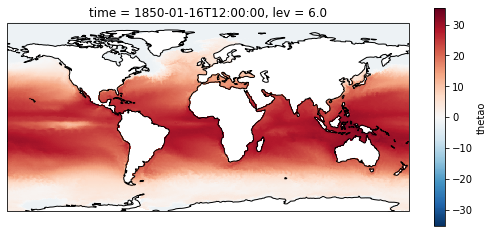

In [13]:
plt.figure(figsize=(9,4));
ax = plt.axes(projection=ccrs.PlateCarree());
ds_remap.thetao.isel(time=0, lev=0).plot.pcolormesh(ax=ax, x="lon", y="lat", shading="flat");
ax.coastlines();

<a id='clisops.core.Grid'></a>
## `clisops.core.Grid`

<i>(Scroll to the [top](#top))</i>

### Create a grid object from an `xarray.Dataset`

##### Load the dataset

In [14]:
dso_path = Path(MINIESGF, "badc/cmip6/data/CMIP6/CMIP/MPI-M/MPI-ESM1-2-HR/historical/r1i1p1f1/Omon/tos/gn/"
                          "v20190710/tos_Omon_MPI-ESM1-2-HR_historical_r1i1p1f1_gn_185001.nc")
dso = xr.open_dataset(dso_path)
dso

<xarray.Dataset>
Dimensions:             (bnds: 2, i: 802, j: 404, time: 1, vertices: 4)
Coordinates:
  * i                   (i) int32 0 1 2 3 4 5 6 ... 795 796 797 798 799 800 801
  * j                   (j) int32 0 1 2 3 4 5 6 ... 397 398 399 400 401 402 403
    latitude            (j, i) float64 ...
    longitude           (j, i) float64 ...
  * time                (time) datetime64[ns] 1850-01-16T12:00:00
Dimensions without coordinates: bnds, vertices
Data variables:
    time_bnds           (time, bnds) datetime64[ns] ...
    tos                 (time, j, i) float32 ...
    vertices_latitude   (j, i, vertices) float64 ...
    vertices_longitude  (j, i, vertices) float64 ...
Attributes: (12/48)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    contact:                cmip6-mpi-esm@dkrz.de
    ...                     ...
    variable_id:            tos
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by MPI-M is licensed un...
    cmor_version:           3.5.0
    tracking_id:            hdl:21.14100/ccd8388f-4f80-4a1e-ba47-66fe65bbeece
    NCO:                    netCDF Operators version 4.7.8 (Homepage = http:/...

##### Create the Grid object

In [15]:
grido = clore.Grid(ds=dso)
grido

clisops 402x800_cells_grid
Lat x Lon:        402 x 800
Gridcells:        321600
Format:           CF
Type:             curvilinear
Extent:           global
Source:           Dataset
Bounds?           True
Collapsing cells? False
Permanent Mask:   None
md5 hash:         a866a9d2a15b27df690c4df58d3e126a

The `xarray.Dataset` is attached to the `clisops.core.Grid` object. Auxiliary coordinates and data variables have been (re)set appropriately.

In [16]:
grido.ds

<xarray.Dataset>
Dimensions:             (bnds: 2, i: 800, j: 402, time: 1, vertices: 4)
Coordinates:
  * i                   (i) int32 0 1 2 3 4 5 6 ... 793 794 795 796 797 798 799
  * j                   (j) int32 0 1 4 5 6 7 8 ... 397 398 399 400 401 402 403
    latitude            (j, i) float64 51.15 51.15 51.15 ... -78.67 -78.67
    longitude           (j, i) float64 83.1 83.06 83.01 ... 81.5 81.95 82.4
  * time                (time) datetime64[ns] 1850-01-16T12:00:00
    time_bnds           (time, bnds) datetime64[ns] 1850-01-01 1850-02-01
    vertices_latitude   (j, i, vertices) float64 51.49 51.39 ... -78.67 -78.48
    vertices_longitude  (j, i, vertices) float64 83.01 83.0 ... 82.63 82.63
Dimensions without coordinates: bnds, vertices
Data variables:
    tos                 (time, j, i) float32 ...
Attributes: (12/48)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    contact:                cmip6-mpi-esm@dkrz.de
    ...                     ...
    variable_id:            tos
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by MPI-M is licensed un...
    cmor_version:           3.5.0
    tracking_id:            hdl:21.14100/ccd8388f-4f80-4a1e-ba47-66fe65bbeece
    NCO:                    netCDF Operators version 4.7.8 (Homepage = http:/...

##### Plot the data

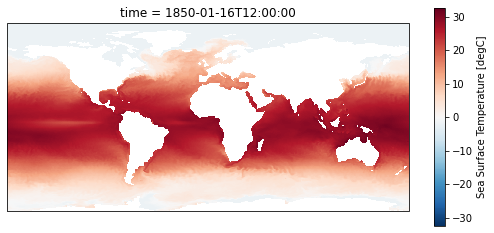

In [17]:
plt.figure(figsize=(9,4));
ax = plt.axes(projection=ccrs.PlateCarree());
grido.ds.tos.isel(time=0).plot.pcolormesh(ax=ax, x=grido.lon, y=grido.lat, shading="flat");

### Create a grid object from an `xarray.DataArray`

Note that `xarray.DataArray` objects do not support the bounds of coordinate variables to be defined.

##### Extract tos `DataArray`

In [18]:
dao = dso.tos
dao

<xarray.DataArray 'tos' (time: 1, j: 404, i: 802)>
[324008 values with dtype=float32]
Coordinates:
  * i          (i) int32 0 1 2 3 4 5 6 7 8 ... 794 795 796 797 798 799 800 801
  * j          (j) int32 0 1 2 3 4 5 6 7 8 ... 396 397 398 399 400 401 402 403
    latitude   (j, i) float64 51.15 51.15 51.15 51.15 ... -78.67 -78.67 -78.67
    longitude  (j, i) float64 83.1 83.06 83.01 82.96 ... 81.95 82.4 82.85 83.3
  * time       (time) datetime64[ns] 1850-01-16T12:00:00
Attributes:
    standard_name:  sea_surface_temperature
    long_name:      Sea Surface Temperature
    comment:        Temperature of upper boundary of the liquid ocean, includ...
    units:          degC
    original_name:  tos
    cell_methods:   area: mean where sea time: mean
    cell_measures:  area: areacello
    history:        2019-08-25T06:00:45Z altered by CMOR: replaced missing va...

##### Create Grid object for MPIOM tos dataarray:

In [19]:
grido_tos = clore.Grid(ds=dao)
grido_tos

clisops 402x800_cells_grid
Lat x Lon:        402 x 800
Gridcells:        321600
Format:           CF
Type:             curvilinear
Extent:           global
Source:           Dataset
Bounds?           False
Collapsing cells? None
Permanent Mask:   None
md5 hash:         e89c12fe921ef40cded17a43ae7b68ab

### Create a grid object using a `grid_instructor`

* global grid: `grid_instructor = (lon_step, lat_step)` or `grid_instructor = step`
* regional grid:`grid_instructor = (lon_start, lon_end, lon_step, lat_start, lat_end, lat_step)` or `grid_instructor = (start, end, step)` 

In [20]:
grid_1deg = clore.Grid(grid_instructor=1)
grid_1deg

clisops 180x360_cells_grid
Lat x Lon:        180 x 360
Gridcells:        64800
Format:           CF
Type:             regular_lat_lon
Extent:           global
Source:           xESMF
Bounds?           True
Collapsing cells? False
Permanent Mask:   None
md5 hash:         ff485fa62d5f72e2db23980e3c76efa7

In [21]:
grid_1degx2deg_regional = clore.Grid(grid_instructor=(0., 90., 1., 35., 50., 2. ))
grid_1degx2deg_regional

clisops 8x90_cells_grid
Lat x Lon:        8 x 90
Gridcells:        720
Format:           CF
Type:             regular_lat_lon
Extent:           regional
Source:           xESMF
Bounds?           True
Collapsing cells? False
Permanent Mask:   None
md5 hash:         f10055f7eb2bdc8733e40cc2857fe3e9

### Create a grid object using a `grid_id`

Makes use of the predefined grids of `roocs_grids`, which is a collection of grids used for example for the [IPCC Atlas](https://github.com/IPCC-WG1/Atlas/tree/main/reference-grids) and for [CMIP6 Regridding Weights generation](https://docs.google.com/document/d/1BfVVsKAk9MAsOYstwFSWI2ZBt5mrO_Nmcu7rLGDuL08/edit).

In [22]:
for key, gridinfo in grid_annotations.items(): print(f"- {key:20} {gridinfo}")

- 0pt25deg             Global 0.25 degree grid with one cell centered at 0.125E,0.125N 
- World_Ocean_Atlas    Global 1.0 degree grid with one cell centered at 0.5E,0.5N. As used by the World Ocean Atlas.
- 1deg                 Global 1.0 degree grid with one cell centered at 0.5E,0.5N. As used by the World Ocean Atlas.
- 2pt5deg              Global 2.5 degree grid with one cell centered at 1.25E,1.25N.
- MERRA-2              Global 0.65x0.5 (latxlon) degree grid with one cell centered at 0E,0N. As used by MERRA-2.
- 0pt625x0pt5deg       Global 0.65x0.5 (latxlon) degree grid with one cell centered at 0E,0N. As used by MERRA-2.
- ERA-Interim          Global 0.75 degree grid with one cell centered at 0E,0N. As used by ERA-Interim.
- 0pt75deg             Global 0.75 degree grid with one cell centered at 0E,0N. As used by ERA-Interim.
- ERA-40               Global 1.25 degree grid with one cell centered at 0E,0N. As used by ERA-40.
- 1pt25deg             Global 1.25 degree grid with one ce

In [23]:
grid_era5 = clore.Grid(grid_id = "0pt25deg_era5")
grid_era5

clisops 721x1440_cells_grid
Lat x Lon:        721 x 1440
Gridcells:        1038240
Format:           CF
Type:             regular_lat_lon
Extent:           global
Source:           Predefined_0pt25deg_era5
Bounds?           True
Collapsing cells? False
Permanent Mask:   None
md5 hash:         cdf4f59eab828857bc0c2819c0c465d7

### `clisops.core.Grid` objects can be compared to one another

##### Compare the tos dataset to the tos dataarray

In [24]:
comp = grido.compare_grid(grido_tos, verbose = True)
print("Grids are equal?", comp)

The two grids differ in their respective lat_bnds, lon_bnds.
Grids are equal? False


##### Compare both 0.25° ERA5 Grids

In [25]:
# Create the Grid object
grid_era5_lsm = clore.Grid(grid_id = "0pt25deg_era5_lsm", compute_bounds=True)

In [26]:
# Compare
comp = grid_era5.compare_grid(grid_era5_lsm, verbose=True)
print("Grids are equal?", comp)

The two grids are considered equal.
Grids are equal? True


### Strip `clisops.core.Grid` objects of all `data_vars` and `coords` unrelated to the horizontal grid

In [27]:
grid_era5_lsm.ds

<xarray.Dataset>
Dimensions:    (bnds: 2, latitude: 721, longitude: 1440, time: 1)
Coordinates:
  * longitude  (longitude) float64 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 2010-01-01
    lat_bnds   (latitude, bnds) float64 89.88 90.0 89.62 ... -89.62 -90.0 -89.88
    lon_bnds   (longitude, bnds) float64 -0.125 0.125 0.125 ... 359.6 359.9
Dimensions without coordinates: bnds
Data variables:
    lsm        (time, latitude, longitude) float32 ...
    z          (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2020-10-21 11:41:35 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

The parameter `keep_attrs` can be set, the default is `False`.

In [28]:
grid_era5_lsm._drop_vars(keep_attrs=False)
grid_era5_lsm.ds

<xarray.Dataset>
Dimensions:    (bnds: 2, latitude: 721, longitude: 1440)
Coordinates:
  * longitude  (longitude) float64 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
    lat_bnds   (latitude, bnds) float64 89.88 90.0 89.62 ... -89.62 -90.0 -89.88
    lon_bnds   (longitude, bnds) float64 -0.125 0.125 0.125 ... 359.6 359.9
Dimensions without coordinates: bnds
Data variables:
    *empty*

### Transfer coordinate variables between `clisops.core.Grid` objects that are unrelated to the horizontal grid

The parameter `keep_attrs` can be set, the default is `True`. All settings for `keep_attrs` are described later in section [clisops.core.regrid](#clisops.core.regrid).

##### Load the dataset

In [29]:
ds_vert_path = Path(MINIESGF, "badc/cmip6/data/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/historical/r1i1p1f1/"
                              "AERmon/o3/gn/v20190710/o3_AERmon_MPI-ESM1-2-LR_historical_r1i1p1f1_gn_185001.nc")
ds_vert = xr.open_dataset(ds_vert_path)
ds_vert

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 96, lev: 3, lon: 192, time: 1)
Coordinates:
  * time       (time) datetime64[ns] 1850-01-16T12:00:00
  * lon        (lon) float64 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
  * lat        (lat) float64 -88.57 -86.72 -84.86 -83.0 ... 84.86 86.72 88.57
  * lev        (lev) float64 0.9961 0.9826 0.959
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] ...
    lon_bnds   (lon, bnds) float64 ...
    lat_bnds   (lat, bnds) float64 ...
    lev_bnds   (lev, bnds) float64 ...
    ap         (lev) float64 ...
    b          (lev) float64 ...
    ap_bnds    (lev, bnds) float64 ...
    b_bnds     (lev, bnds) float64 ...
    ps         (time, lat, lon) float32 ...
    o3         (time, lev, lat, lon) float32 ...
Attributes: (12/49)
    CDI:                    Climate Data Interface version 1.9.8 (https://mpi...
    history:                Tue Oct 26 11:48:46 2021: cdo sellevidx,1/3 -selt...
    source:                 MPI-ESM1.2-LR (2017): \naerosol: none, prescribed...
    institution:            Max Planck Institute for Meteorology
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    ...                     ...
    variable_id:            o3
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by MPI-M is licensed un...
    cmor_version:           3.5.0
    tracking_id:            hdl:21.14100/52bee89e-e989-4005-8663-e60210d421d5
    CDO:                    Climate Data Operators version 1.9.8 (https://mpi...

##### Create grid object

In [30]:
grid_vert = clore.Grid(ds_vert)
grid_vert

clisops 96x192_cells_grid
Lat x Lon:        96 x 192
Gridcells:        18432
Format:           CF
Type:             regular_lat_lon
Extent:           global
Source:           Dataset
Bounds?           True
Collapsing cells? False
Permanent Mask:   None
md5 hash:         20d38455170b1db562edb4f5e06d3cc6

##### Transfer the coordinates to the ERA5 grid object

In [31]:
grid_era5_lsm._transfer_coords(grid_vert, keep_attrs=True)
grid_era5_lsm.ds

<xarray.Dataset>
Dimensions:    (bnds: 2, latitude: 721, lev: 3, longitude: 1440, time: 1)
Coordinates:
  * longitude  (longitude) float64 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
    lat_bnds   (latitude, bnds) float64 89.88 90.0 89.62 ... -89.62 -90.0 -89.88
    lon_bnds   (longitude, bnds) float64 -0.125 0.125 0.125 ... 359.6 359.9
  * time       (time) datetime64[ns] 1850-01-16T12:00:00
    time_bnds  (time, bnds) datetime64[ns] 1850-01-01 1850-02-01
    ap         (lev) float64 0.0 0.0 36.03
    b          (lev) float64 0.9961 0.9826 0.9586
  * lev        (lev) float64 0.9961 0.9826 0.959
    ap_bnds    (lev, bnds) float64 0.0 0.0 0.0 0.0 0.0 72.06
    b_bnds     (lev, bnds) float64 1.0 0.9923 0.9923 0.973 0.973 0.9442
    lev_bnds   (lev, bnds) float64 1.0 0.9923 0.9923 0.973 0.973 0.9449
Dimensions without coordinates: bnds
Data variables:
    *empty*
Attributes: (12/49)
    CDI:                    Climate Data Interface version 1.9.8 (https://mpi...
    history:                Tue Oct 26 11:48:46 2021: cdo sellevidx,1/3 -selt...
    source:                 MPI-ESM1.2-LR (2017): \naerosol: none, prescribed...
    institution:            Max Planck Institute for Meteorology
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    ...                     ...
    variable_id:            o3
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by MPI-M is licensed un...
    cmor_version:           3.5.0
    tracking_id:            hdl:21.14100/52bee89e-e989-4005-8663-e60210d421d5
    CDO:                    Climate Data Operators version 1.9.8 (https://mpi...

<a id='clisops.core.Weights'></a>
## `clisops.core.Weights`
<i>(Scroll to the [top](#top))</i>

Create regridding weights to regrid between two grids. Supported are the following of [xESMF's remapping methods](https://pangeo-xesmf.readthedocs.io/en/latest/notebooks/Compare_algorithms.html):
* `nearest_s2d`
* `bilinear`
* `conservative`
* `patch`

##### Create 2-degree target grid

In [32]:
grid_2deg = clore.Grid(grid_id="2deg_lsm", compute_bounds=True)
grid_2deg

clisops 90x180_cells_grid
Lat x Lon:        90 x 180
Gridcells:        16200
Format:           CF
Type:             regular_lat_lon
Extent:           global
Source:           Predefined_2deg_lsm
Bounds?           True
Collapsing cells? False
Permanent Mask:   None
md5 hash:         438f79b4376004d360a56fa2c0abb9f0

##### Create the remapping weights using the `clisops.core.Weights` class

`grid_in` and `grid_out` are `Grid` objects

In [33]:
%time weights = clore.Weights(grid_in = grido, grid_out = grid_2deg, method="conservative")

CPU times: user 9.23 s, sys: 216 ms, total: 9.45 s
Wall time: 9.46 s


##### Local weights cache

Weights are cached on disk and do not have to be created again. The default cache directory is `/tmp/clisops_grid_weights` and can be adjusted either in the `roocs.ini` configuration file that can be found in the clisops installation directory or via:
```python
from clisops import core as clore
clore.weights_cache_init("/dir/for/weights/cache")
```

In [34]:
!ls /tmp/clisops_grid_weights

grid_05603f6f046b266ba6bc164c5b3209bf.nc
grid_20d38455170b1db562edb4f5e06d3cc6.nc
grid_438f79b4376004d360a56fa2c0abb9f0.nc
grid_a866a9d2a15b27df690c4df58d3e126a.nc
grid_cbfbd94fc4feee0c6b34841124e4adf8.nc
grid_d24f4f689f12099406e6b95115553334.nc
grid_e2c8b52440eb2392c600702aa1c532ef.nc
grid_ec7db0ee9226e085bfe8207b8de0672d.nc
weights_05603f6f046b266ba6bc164c5b3209bf_cbfbd94fc4feee0c6b34841124e4adf8_bilinear.nc
weights_20d38455170b1db562edb4f5e06d3cc6_d24f4f689f12099406e6b95115553334_peri_bilinear.nc
weights_a866a9d2a15b27df690c4df58d3e126a_438f79b4376004d360a56fa2c0abb9f0_peri_conservative.nc
weights_ec7db0ee9226e085bfe8207b8de0672d_e2c8b52440eb2392c600702aa1c532ef_peri_nearest_s2d.nc
weights.json


In [35]:
!cat /tmp/clisops_grid_weights/weights.json

{
    "05603f6f046b266ba6bc164c5b3209bf_cbfbd94fc4feee0c6b34841124e4adf8_bilinear": {
        "def_filename": "bilinear_201x225_201x225.nc",
        "filename": "weights_05603f6f046b266ba6bc164c5b3209bf_cbfbd94fc4feee0c6b34841124e4adf8_bilinear.nc",
        "format": "xESMF",
        "ignore_degenerate": "None",
        "method": "bilinear",
        "periodic": "False",
        "source_extent": "regional",
        "source_format": "CF",
        "source_lat": "lat",
        "source_lat_bnds": "lat_vertices",
        "source_lon": "lon",
        "source_lon_bnds": "lon_vertices",
        "source_ncells": 45225,
        "source_nlat": 201,
        "source_nlon": 225,
        "source_source": "/home/maurti/.mini-esgf-data/master/test_data/pool/data/CORDEX/data/cordex/output/EUR-22/GERICS/MPI-M-MPI-ESM-LR/rcp85/r1i1p1/GERICS-REMO2015/v1/mon/tas/v20191029/tas_EUR-22_MPI-M-MPI-ESM-LR_rcp85_r1i1p1_GERICS-REMO2015_v1_mon_202101.nc",
        "source_tracking_id": "hdl:21.14103/77bb3489-7951-4f31

Now the weights will be read directly from the cache

In [36]:
%time weights = clore.Weights(grid_in = grido, grid_out = grid_2deg, method="conservative")

CPU times: user 225 ms, sys: 16.1 ms, total: 241 ms
Wall time: 240 ms


The weights cache can be flushed, which removes all weight and grid files as well as the json file holding the metadata. To see what would be removed, one can use the `dryrun=True` parameter. To re-initialize the weights cache in a different directory, one can use the `weights_dir_init="/new/dir/for/weights/cache"` parameter. Even when re-initializing the weights cache under a new path, using `clore.weights_cache_flush`, no directory is getting removed, only above listed files. When `dryrun` is not set, the files that are getting deleted can be displayed with `verbose=True`.

In [37]:
clore.weights_cache_flush(dryrun=True)

Flushing the clisops weights cache would remove:
 - /tmp/clisops_grid_weights/weights.json
 - /tmp/clisops_grid_weights/weights_20d38455170b1db562edb4f5e06d3cc6_d24f4f689f12099406e6b95115553334_peri_bilinear.nc
 - /tmp/clisops_grid_weights/weights_ec7db0ee9226e085bfe8207b8de0672d_e2c8b52440eb2392c600702aa1c532ef_peri_nearest_s2d.nc
 - /tmp/clisops_grid_weights/weights_a866a9d2a15b27df690c4df58d3e126a_438f79b4376004d360a56fa2c0abb9f0_peri_conservative.nc
 - /tmp/clisops_grid_weights/weights_05603f6f046b266ba6bc164c5b3209bf_cbfbd94fc4feee0c6b34841124e4adf8_bilinear.nc
 - /tmp/clisops_grid_weights/grid_ec7db0ee9226e085bfe8207b8de0672d.nc
 - /tmp/clisops_grid_weights/grid_20d38455170b1db562edb4f5e06d3cc6.nc
 - /tmp/clisops_grid_weights/grid_cbfbd94fc4feee0c6b34841124e4adf8.nc
 - /tmp/clisops_grid_weights/grid_a866a9d2a15b27df690c4df58d3e126a.nc
 - /tmp/clisops_grid_weights/grid_05603f6f046b266ba6bc164c5b3209bf.nc
 - /tmp/clisops_grid_weights/grid_e2c8b52440eb2392c600702aa1c532ef.nc
 - /tmp

In [38]:
clore.weights_cache_flush(verbose=True)

Flushing the clisops weights cache. Removing ...
 - /tmp/clisops_grid_weights/weights.json
 - /tmp/clisops_grid_weights/weights_20d38455170b1db562edb4f5e06d3cc6_d24f4f689f12099406e6b95115553334_peri_bilinear.nc
 - /tmp/clisops_grid_weights/weights_ec7db0ee9226e085bfe8207b8de0672d_e2c8b52440eb2392c600702aa1c532ef_peri_nearest_s2d.nc
 - /tmp/clisops_grid_weights/weights_a866a9d2a15b27df690c4df58d3e126a_438f79b4376004d360a56fa2c0abb9f0_peri_conservative.nc
 - /tmp/clisops_grid_weights/weights_05603f6f046b266ba6bc164c5b3209bf_cbfbd94fc4feee0c6b34841124e4adf8_bilinear.nc
 - /tmp/clisops_grid_weights/grid_ec7db0ee9226e085bfe8207b8de0672d.nc
 - /tmp/clisops_grid_weights/grid_20d38455170b1db562edb4f5e06d3cc6.nc
 - /tmp/clisops_grid_weights/grid_cbfbd94fc4feee0c6b34841124e4adf8.nc
 - /tmp/clisops_grid_weights/grid_a866a9d2a15b27df690c4df58d3e126a.nc
 - /tmp/clisops_grid_weights/grid_05603f6f046b266ba6bc164c5b3209bf.nc
 - /tmp/clisops_grid_weights/grid_e2c8b52440eb2392c600702aa1c532ef.nc
 - /tmp

In [39]:
%time weights = clore.Weights(grid_in = grido, grid_out = grid_2deg, method="conservative")

CPU times: user 9.17 s, sys: 168 ms, total: 9.34 s
Wall time: 9.35 s


<a id='clisops.core.regrid'></a>
## `clisops.core.regrid`
<i>(Scroll to the [top](#top))</i>

This function allows to perform the eventual regridding and provides a resulting `xarray.Dataset`

```python
def regrid(grid_in, grid_out, weights, adaptive_masking_threshold=0.5, keep_attrs=True):
```

* `grid_in` and `grid_out` are `Grid` objects, `weights` is a `Weights` object.
* `adaptive_masking_threshold` (AMT) A value within the [0., 1.] interval that defines the maximum `RATIO` of missing_values amongst the total number of data values contributing to the calculaton of the target grid cell value. For a fraction [0., AMT[ of the contributing source data missing, the target grid cell will be set to missing_value, else, it will be renormalized by `1.-RATIO`. Thus, if AMT is set to 1, all source grid cells that contribute to a target grid cell must be missing in order for the target grid cell to be defined as missing itself. Values greater than 1 or less than 0 will cause adaptive masking to be turned off. This adaptive masking technique allows to reuse generated weights for differently masked data (eg. land-sea masks or orographic masks that vary with depth / height).
*`keep_attrs` can have the following settings:
  * `True` : The resulting `xarray.Dataset` will have all attributes of `grid_in.ds.attrs`, despite attributes that have to be added and altered due to the new grid. 
  * `False` : The resulting `xarray.Dataset` will have no attributes despite attributes generated by the regridding process.
  * `"target"` : The resulting `xarray.Dataset` will have all attributes of `grid_out.ds.attrs`, despite attributes generated by the regridding process. Not recommended.
  
  
#### In the following an example showing the function application and the effect of the adaptive masking.

In [40]:
ds_out_amt0 = clore.regrid(grido, grid_2deg, weights, adaptive_masking_threshold=-1)

In [41]:
ds_out_amt1 = clore.regrid(grido, grid_2deg, weights, adaptive_masking_threshold=0.5)

##### Plot the resulting data

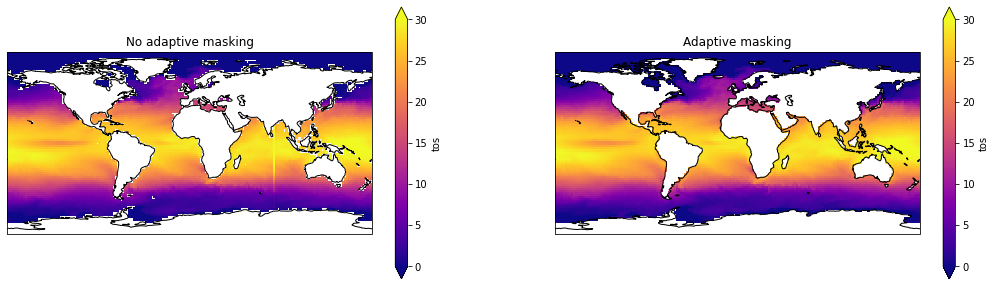

In [42]:
# Create panel plot of regridded data (global)
fig, axes = plt.subplots(ncols=2, nrows=1, 
                         figsize=(18, 5), # global
                         subplot_kw={'projection': ccrs.PlateCarree()})

ds_out_amt0["tos"].isel(time=0).plot.pcolormesh(ax=axes[0], vmin=0, vmax=30, cmap="plasma");
axes[0].title.set_text("No adaptive masking");

ds_out_amt1["tos"].isel(time=0).plot.pcolormesh(ax=axes[1], vmin=0, vmax=30, cmap="plasma");
axes[1].title.set_text("Adaptive masking");

for axis in axes.flatten():
    axis.coastlines();
    axis.set_xlabel('lon');
    axis.set_ylabel('lat');

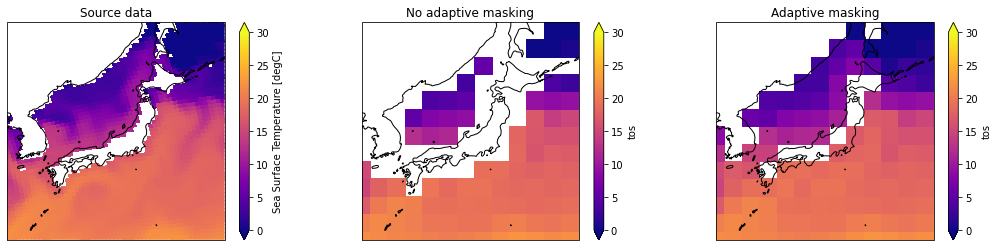

In [43]:
# Create panel plot of regridded data (Japan)
fig, axes = plt.subplots(ncols=3, nrows=1, 
                         figsize=(18, 4), # Japan
                         subplot_kw={'projection': ccrs.PlateCarree()})

grido.ds.tos.isel(time=0).plot.pcolormesh(ax=axes[0], x=grido.lon, y=grido.lat, 
                                          vmin=0, vmax=30, cmap="plasma", shading="flat");
axes[0].title.set_text("Source data");

ds_out_amt0["tos"].isel(time=0).plot.pcolormesh(ax=axes[1], vmin=0, vmax=30, cmap="plasma");
axes[1].title.set_text("No adaptive masking");

ds_out_amt1["tos"].isel(time=0).plot.pcolormesh(ax=axes[2], vmin=0, vmax=30, cmap="plasma");
axes[2].title.set_text("Adaptive masking");

for axis in axes.flatten():
    axis.coastlines();
    axis.set_xlabel('lon');
    axis.set_ylabel('lat');
    axis.set_xlim([125, 150]);
    axis.set_ylim([25, 50]);